In [63]:
import pm4py
import pandas as pd
import time
import matplotlib.pyplot as plt
import Levenshtein as lv
from paretoset import paretoset

version = 6
file_name = "syn_3"
attribute_key = "property_lt_20"

case_attribute_key = f'case:{attribute_key}'
case_id_key = "case:concept:name"

In [64]:
log = pm4py.read_xes(f'logs/{file_name}.xes')

parsing log, completed traces :: 100%|██████████| 10000/10000 [00:01<00:00, 6488.80it/s]


In [65]:
df = pm4py.convert_to_dataframe(log)
df = df.dropna(subset=[case_attribute_key]).reset_index() # filter empty rows

In [66]:
pm4py.get_stochastic_language(df)

{('B',
  'B',
  'P2',
  'P2',
  'P3',
  'P3',
  'P5',
  'P5',
  'P7',
  'P7',
  'P9',
  'P9'): 0.0003,
 ('B',
  'B',
  'P2',
  'P2',
  'P3',
  'P3',
  'P7',
  'P7',
  'P8',
  'P8',
  'P10',
  'P10'): 0.001,
 ('B',
  'B',
  'P2',
  'P2',
  'P3',
  'P3',
  'P4',
  'P4',
  'P5',
  'P5',
  'P6',
  'P6',
  'P7',
  'P7',
  'P10',
  'P10'): 0.001,
 ('B',
  'B',
  'P1',
  'P1',
  'P2',
  'P2',
  'P4',
  'P4',
  'P5',
  'P5',
  'P6',
  'P6',
  'P7',
  'P7'): 0.0006,
 ('B',
  'B',
  'P3',
  'P3',
  'P5',
  'P5',
  'P7',
  'P7',
  'P8',
  'P8',
  'P10',
  'P10'): 0.0012,
 ('A', 'A', 'P3', 'P3', 'P5', 'P5', 'P8', 'P8'): 0.0003,
 ('B', 'B', 'P2', 'P2', 'P4', 'P4', 'P5', 'P5', 'P10', 'P10'): 0.0008,
 ('B',
  'B',
  'P2',
  'P2',
  'P3',
  'P3',
  'P4',
  'P4',
  'P5',
  'P5',
  'P9',
  'P9'): 0.0009,
 ('B', 'B', 'P3', 'P3', 'P4', 'P4', 'P5', 'P5', 'P6', 'P6'): 0.0011,
 ('B', 'B', 'P1', 'P1', 'P4', 'P4', 'P6', 'P6', 'P7', 'P7'): 0.0009,
 ('A', 'A', 'P1', 'P1', 'P2', 'P2', 'P6', 'P6', 'P7', 'P7'): 0.0

In [67]:
def uEMSC(l, m):
    return 1 - sum([ max(pr - (m.get(tr) or 0), 0) for tr, pr in l.items() if pr > 0 ])

In [68]:
def Gini(l, m):
    n1 = len(l)
    n2 = len(m)
    n = n1 + n2
    return (n1/n) * (1 - sum([ pr**2 for pr in l.values() ])) + (n2/n) * (1 - sum([ pr**2 for pr in m.values() ]))

In [69]:
variants = pm4py.get_variants_as_tuples(df)
activities = {}

for (v, o) in variants.items():
    for a in v:
        activities[a] = activities.setdefault(a, 0) + o

activities = dict(sorted(activities.items(), key=lambda x: x[1], reverse=True))
activity_to_char = { k: chr(i) for i, (k, v) in enumerate(activities.items()) }
len(activity_to_char)

12

In [70]:
# # test that our char hack works
# for (a1, c1) in activity_to_char.items():
#     for (a2, c2) in activity_to_char.items():
#         if (a1 == a2): continue
#         d = lv.distance(c1, c2)
#         if (d == 0): print(f'{c1}, {c2}, {d}')

In [71]:
# # test that our char hack works
# for (a1, c1) in activity_to_char.items():
#     for (a2, c2) in activity_to_char.items():
#         for (a3, c3) in activity_to_char.items():
#             if (a1 == a2): continue
#             d = lv.distance(c1 + c3, c2)
#             if (d == 0): print(f'{c1} + {c3}, {c2}, {d}')

In [72]:
def trace_to_string(t):
    return "".join([ activity_to_char[a] for a in t ])

In [73]:
def Indel(l, m, sl, sm):
    lt_string_log = { trace_to_string(k): v for k, v in l.items() }
    gte_string_log = { trace_to_string(k): v for k, v in m.items() if v > 0 }
    
    Is_sum = 0
    for (lt_s, lt_o) in lt_string_log.items():
        for (gte_s, gte_o) in gte_string_log.items():
            Is_sum += lv.ratio(lt_s, gte_s) * lt_o * gte_o
    
    return Is_sum / (sl * sm)

In [74]:
def Hamming(l, m, sl, sm):
    lt_string_log = { trace_to_string(k): v for k, v in l.items() }
    gte_string_log = { trace_to_string(k): v for k, v in m.items() if v > 0 }
    
    hd_sum = 0
    for (lt_s, lt_o) in lt_string_log.items():
        for (gte_s, gte_o) in gte_string_log.items():
            hd_sum += lv.hamming(lt_s, gte_s) * lt_o * gte_o
    
    return hd_sum / (sl * sm)

In [75]:
def Jaro(l, m, sl, sm):
    lt_string_log = { trace_to_string(k): v for k, v in l.items() }
    gte_string_log = { trace_to_string(k): v for k, v in m.items() if v > 0 }
    
    js_sum = 0
    for (lt_s, lt_o) in lt_string_log.items():
        for (gte_s, gte_o) in gte_string_log.items():
            js_sum += lv.jaro(lt_s, gte_s) * lt_o * gte_o
    
    return js_sum / (sl * sm)

In [76]:
def Hamming_var(l, m, sl, sm):
    lt_string_log = { trace_to_string(k): v for k, v in l.items() }
    gte_string_log = { trace_to_string(k): v for k, v in m.items() if v > 0 }
    
    hd_sum_A = 0
    for (lt_s1, lt_o1) in lt_string_log.items():
        for (lt_s2, lt_o2) in lt_string_log.items():
            hd_sum_A += lv.hamming(lt_s1, lt_s2) * lt_o1 * lt_o2
    hd_sum_A = hd_sum_A / (sl * sl)

    hd_sum_B = 0
    for (gte_s1, gte_o1) in gte_string_log.items():
        for (gte_s2, gte_o2) in gte_string_log.items():
            hd_sum_B += lv.hamming(gte_s1, gte_s2) * gte_o1 * gte_o2
    hd_sum_B = hd_sum_B / (sm * sm)
    
    return hd_sum_A ** 2 + hd_sum_B ** 2

In [77]:
def Hamming_var_A(l, sl):
    lt_string_log = { trace_to_string(k): v for k, v in l.items() }
    
    hd_sum_A = 0
    for (lt_s1, lt_o1) in lt_string_log.items():
        for (lt_s2, lt_o2) in lt_string_log.items():
            hd_sum_A += lv.hamming(lt_s1, lt_s2) * lt_o1 * lt_o2
    hd_sum_A = hd_sum_A / (sl * sl)
    
    return hd_sum_A

In [93]:
def Indel_var(l, m, sl, sm, exp):
    lt_string_log = { trace_to_string(k): v for k, v in l.items() }
    gte_string_log = { trace_to_string(k): v for k, v in m.items() if v > 0 }
    
    Is_sum_A = 0
    for (lt_s1, lt_o1) in lt_string_log.items():
        for (lt_s2, lt_o2) in lt_string_log.items():
            Is_sum_A += lv.ratio(lt_s1, lt_s2) * lt_o1 * lt_o2
    Is_sum_A = Is_sum_A / (sl * sl)

    Is_sum_B = 0
    for (gte_s1, gte_o1) in gte_string_log.items():
        for (gte_s2, gte_o2) in gte_string_log.items():
            Is_sum_B += lv.ratio(gte_s1, gte_s2) * gte_o1 * gte_o2
    Is_sum_B = Is_sum_B / (sm * sm)
    
    return Is_sum_A ** exp + Is_sum_B ** exp

In [94]:
case_attribute_key = f'case:{attribute_key}'

attribute_values = pm4py.get_trace_attribute_values(df, attribute_key)
sorted_attribute_values = sorted([ float(k) for k in attribute_values.keys() ])

# group df by case ids
grouped = df.filter([case_id_key, case_attribute_key]).groupby(case_id_key, sort=False)
df_gte_light = grouped.first() # initial gte group

# define absolute languages (counting the occurrence of cases)
# devide absoulte numbers by total number of cases later(!), otherwise every values has to be updated
language_lt = {}
language_gte = pm4py.stats.get_variants(df)

lt_sizes = [0]
gte_sizes = [len(grouped.first().index)]

uemscs = []

ginis = []

Iss = []

Isvs05 = []
Isvs1 = []
Isvs2 = []
Isvs4 = []
Isvs8 = []

hds = []

hdvs = []

hdvas = []
hdvbs = []

jss = []

start_time = time.time()

for idx, pivot in enumerate(sorted_attribute_values[1:]):

    # find affected cases
    df_affected_light = df_gte_light[df_gte_light[case_attribute_key] < pivot]

    # remove affected cases from gte group
    df_gte_light = df_gte_light.drop(df_affected_light.index)

    # translate into full df
    df_affected = pd.concat([ df.loc[grouped.indices[i]] for i in df_affected_light.index ])

    # update absoulte languages
    for tr, n in pm4py.stats.get_variants(df_affected).items():
        language_lt[tr] = language_lt.setdefault(tr, 0) + n
        language_gte[tr] = language_gte[tr] - n

    language_lt_size = sum(language_lt.values(), 0.0)
    language_gte_size = sum(language_gte.values(), 0.0)

    stochastic_language_lt = { k: v / language_lt_size for k, v in language_lt.items() }
    stochastic_language_gte = { k: v / language_gte_size for k, v in language_gte.items() if v > 0 }

    uemsc = uEMSC(stochastic_language_lt, stochastic_language_gte)
    uemscs.append(uemsc)

    gini = Gini(stochastic_language_lt, stochastic_language_gte) 
    ginis.append(gini)
    
    indel = Indel(language_lt, language_gte, language_lt_size, language_gte_size)
    Iss.append(indel)

    indelv05 = Indel_var(language_lt, language_gte, language_lt_size, language_gte_size, 0.5)
    Isvs05.append(indelv05)
    indelv1 = Indel_var(language_lt, language_gte, language_lt_size, language_gte_size, 1)
    Isvs1.append(indelv1)
    indelv2 = Indel_var(language_lt, language_gte, language_lt_size, language_gte_size, 2)
    Isvs2.append(indelv2)
    indelv4 = Indel_var(language_lt, language_gte, language_lt_size, language_gte_size, 4)
    Isvs4.append(indelv4)
    indelv8 = Indel_var(language_lt, language_gte, language_lt_size, language_gte_size, 8)
    Isvs8.append(indelv8)

    hd = Hamming(language_lt, language_gte, language_lt_size, language_gte_size)
    hds.append(hd)

    hdv = Hamming_var(language_lt, language_gte, language_lt_size, language_gte_size)
    hdvs.append(hdv)

    hdva = Hamming_var_A(language_lt, language_lt_size)
    hdvas.append(hdva)
    hdvb = Hamming_var_A(language_gte, language_gte_size)
    hdvbs.append(hdvb)

    js = Jaro(language_lt, language_gte, language_lt_size, language_gte_size)
    jss.append(js)

    print(f'[{idx}/{len(attribute_values) - 1}]: (uEMSC) {uemsc} | (Gini) {gini} | (Indel) {indel} | (Hamming) {hd} | (Hamming_var) {hdv} | (Jaro) {js}')
    
    # collect data to plot graph
    lt_sizes.append(language_lt_size)
    gte_sizes.append(language_gte_size)

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time) 

[0/100]: (uEMSC) 0.011471120949890112 | (Gini) 0.9987449214691362 | (Indel) 0.4356111501481521 | (Hamming) 11.488356844695174 | (Hamming_var) 205.884845540828 | (Jaro) 0.610371049808667
[1/100]: (uEMSC) 0.02855981298912391 | (Gini) 0.9987652767714741 | (Indel) 0.4299153868367769 | (Hamming) 11.617945822146497 | (Hamming_var) 211.81524449507918 | (Jaro) 0.6069917227067246
[2/100]: (uEMSC) 0.04220145805524389 | (Gini) 0.9987887176579978 | (Indel) 0.4272725383239499 | (Hamming) 11.624966412641987 | (Hamming_var) 211.35527002035406 | (Jaro) 0.6052003036402418
[3/100]: (uEMSC) 0.05286617601326793 | (Gini) 0.9987992650593887 | (Indel) 0.42233145018481355 | (Hamming) 11.615980661251527 | (Hamming_var) 209.9470969645499 | (Jaro) 0.6007104856309996
[4/100]: (uEMSC) 0.06086318877015995 | (Gini) 0.9988017492151617 | (Indel) 0.42078393028001543 | (Hamming) 11.623807190040157 | (Hamming_var) 209.12532627709035 | (Jaro) 0.5986293416255792
[5/100]: (uEMSC) 0.06891076532232121 | (Gini) 0.9988112067473

| Algorithm | Times              |
|-----------|--------------------|
| all       | 7.080536603927612  |
|           | 7.4808642864227295 |
|           | 7.335244178771973  |
| uEMSC     | 1.4831063747406006 |
|           | 1.5097837448120117 |
|           | 1.5090765953063965 |
| Gini      | 1.443852424621582  |
|           | 1.4583938121795654 |
|           | 1.5344164371490479 |
| Indel     | 73.826465129852295 |
|           | 3.9117519855499268 |
|           | 3.8922741413116455 |
| Hamming   | 72.172844886779785 |
|           | 2.143202543258667  |
|           | 2.210891008377075  |
| Jaro      | 4.476963520050049  |
|           | 4.497848749160767  |
|           | 4.453091144561768  |

In [95]:
# compute relative frequency of traces with certain attribute values
abs_freq = grouped.first().assign(n=1).groupby([case_attribute_key]).count()["n"].tolist() # get number of traces traces with same attribute value
total = len(grouped.first().index)
rel_freq = [ v / total for v in abs_freq ]

rel_lt_sizes = [ s / total for s in lt_sizes ]
rel_gte_sizes = [ s / total for s in gte_sizes ]

In [96]:
# get 10% & 90% marks

# PROBLEM: if we have a log where not every trace has the attribute in question, then sum(abs_freq) < number_of_traces,
# we should apply a filter here. maybe even to the entire log before processing

alpha = 0.1

bounds_idx = {
    "lower": None, 
    "upper": None
}

target = alpha * total
seen = 0
for (i, freq) in enumerate(abs_freq):
    seen += freq
    if seen >= target:
        bounds_idx["lower"] = i
        break

target = alpha * total
seen = 0
for (i, freq) in reversed(list(enumerate(abs_freq))):
    seen += freq
    if seen >= target:
        bounds_idx["upper"] = i
        break

bounds_idx

{'lower': 10, 'upper': 90}

In [97]:
# sanity check
s = 0
for x in rel_freq[bounds_idx["lower"]:bounds_idx["upper"]]:
    s += x

print(f'% traces in {alpha * 100}-{(1-alpha) * 100} range: {s}')

print(f'rel_lt_sizes at {alpha * 100}% mark: {rel_lt_sizes[bounds_idx["lower"] - 1]} / {rel_lt_sizes[bounds_idx["lower"]]}')
print(f'rel_lt_sizes at {(1 - alpha) * 100}% mark: {rel_lt_sizes[bounds_idx["upper"] - 1]} / {rel_lt_sizes[bounds_idx["upper"]]}')
print(f'rel_gte_sizes at {alpha * 100}% mark: {rel_gte_sizes[bounds_idx["lower"] - 1]} / {rel_gte_sizes[bounds_idx["lower"]]}')
print(f'rel_gte_sizes at {(1 - alpha) * 100}% mark: {rel_gte_sizes[bounds_idx["upper"] - 1]} / {rel_gte_sizes[bounds_idx["upper"]]}')

% traces in 10.0-90.0 range: 0.8012000000000002
rel_lt_sizes at 10.0% mark: 0.0876 / 0.0979
rel_lt_sizes at 90.0% mark: 0.8892 / 0.8991
rel_gte_sizes at 10.0% mark: 0.9124 / 0.9021
rel_gte_sizes at 90.0% mark: 0.1108 / 0.1009


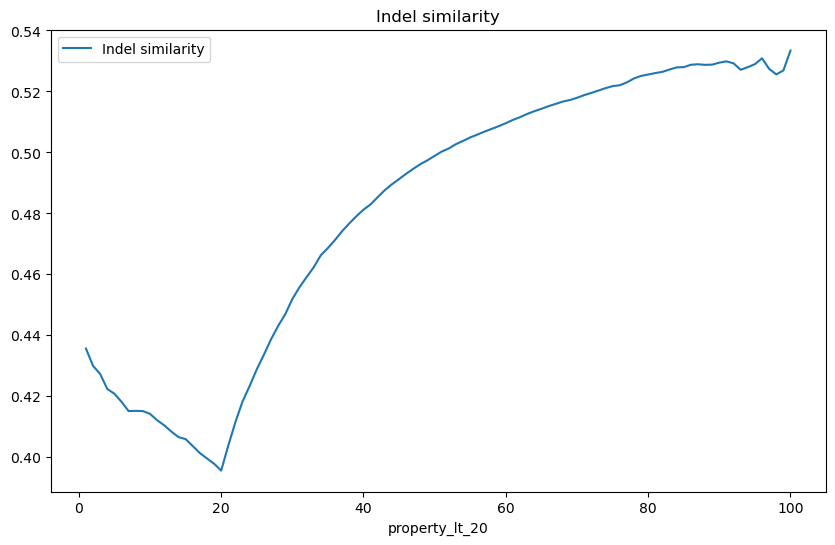

In [98]:
# Indel similarity
plt.figure(figsize=(10,6))
plt.plot(sorted_attribute_values[1:], Iss, label="Indel similarity")
plt.title("Indel similarity")
plt.xlabel(attribute_key)
plt.legend()
plt.show()

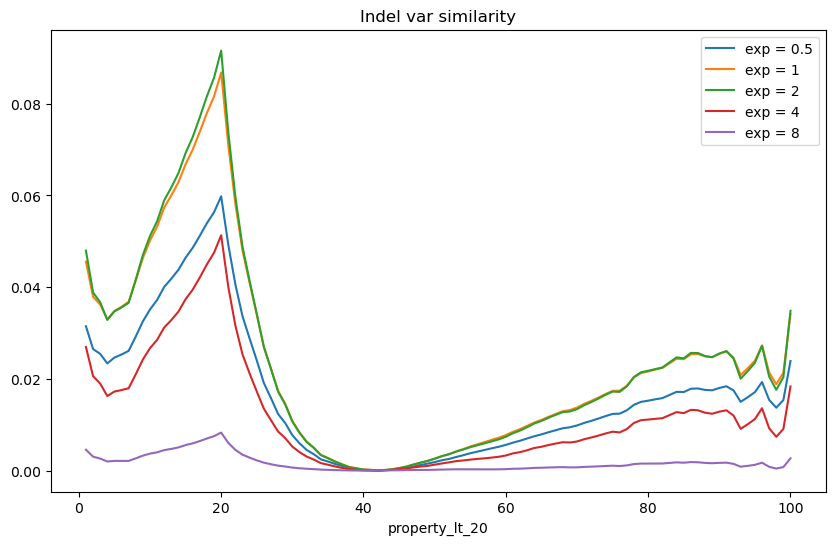

In [107]:
# Indel_var similarity
plt.figure(figsize=(10,6))

plt.plot(sorted_attribute_values[1:], [ v - min(Isvs05) for v in Isvs05 ], label="exp = 0.5")
plt.plot(sorted_attribute_values[1:], [ v - min(Isvs1) for v in Isvs1 ], label="exp = 1")
plt.plot(sorted_attribute_values[1:], [ v - min(Isvs2) for v in Isvs2 ], label="exp = 2")
plt.plot(sorted_attribute_values[1:], [ v - min(Isvs4) for v in Isvs4 ], label="exp = 4")
plt.plot(sorted_attribute_values[1:], [ v - min(Isvs8) for v in Isvs8 ], label="exp = 8")

plt.title("Indel var similarity")
plt.xlabel(attribute_key)
plt.legend()
plt.show()

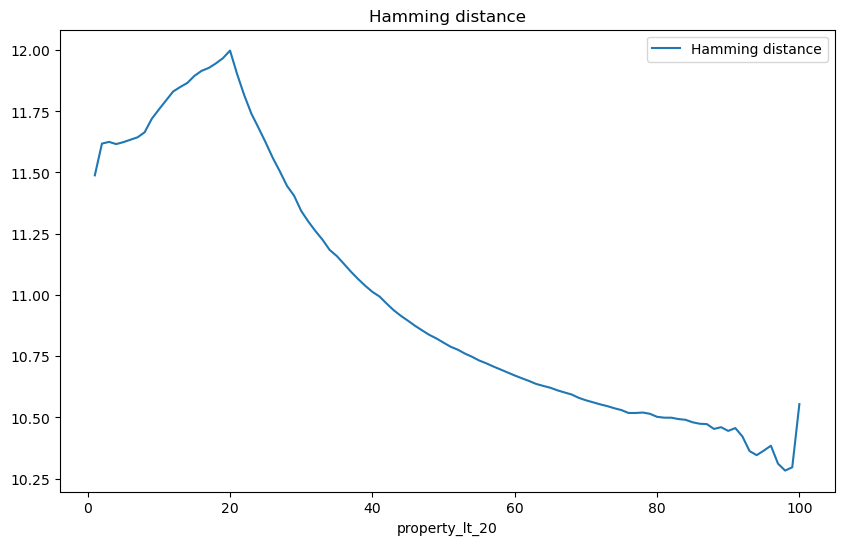

In [100]:
# Hamming distance
plt.figure(figsize=(10,6))
plt.plot(sorted_attribute_values[1:], hds, label="Hamming distance")
plt.title("Hamming distance")
plt.xlabel(attribute_key)
plt.legend()
plt.show()

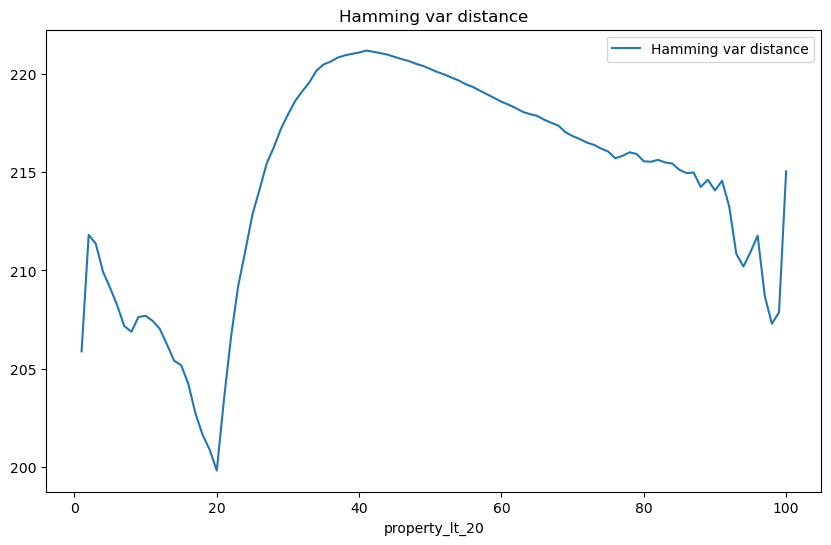

In [101]:
# Hamming_var distance
plt.figure(figsize=(10,6))
plt.plot(sorted_attribute_values[1:], hdvs, label="Hamming var distance")
plt.title("Hamming var distance")
plt.xlabel(attribute_key)
plt.legend()
plt.show()

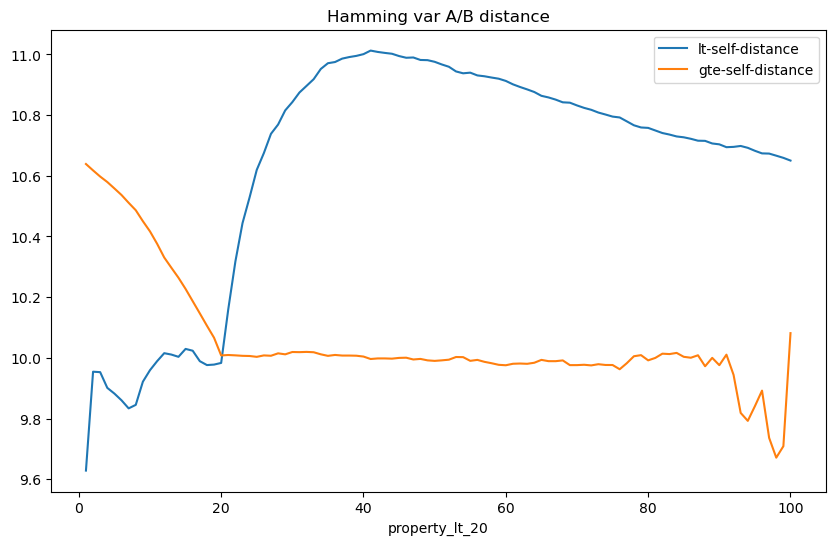

In [102]:
# Hamming_var_A distance
plt.figure(figsize=(10,6))
plt.plot(sorted_attribute_values[1:], hdvas, label="lt-self-distance")
plt.plot(sorted_attribute_values[1:], hdvbs, label="gte-self-distance")
plt.title("Hamming var A/B distance")
plt.xlabel(attribute_key)
plt.legend()
plt.show()

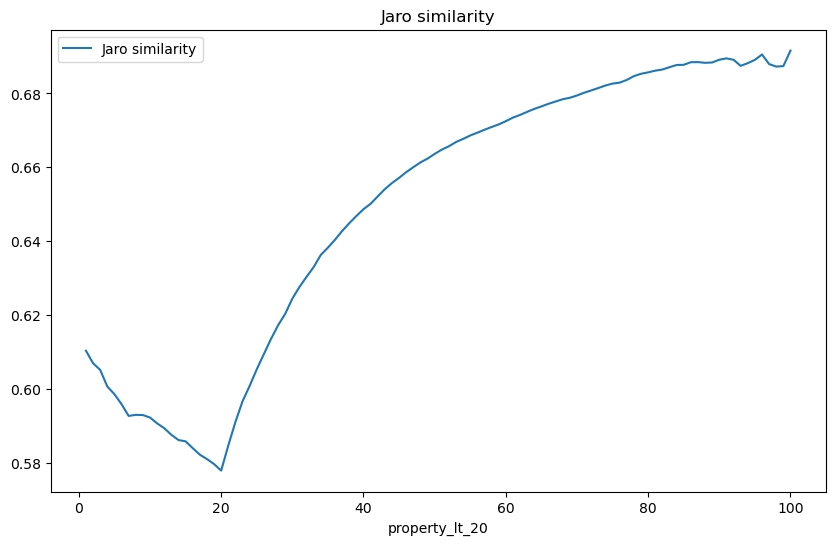

In [103]:
# Jaro similarity
plt.figure(figsize=(10,6))
plt.plot(sorted_attribute_values[1:], jss, label="Jaro similarity")
plt.title("Jaro similarity")
plt.xlabel(attribute_key)
plt.legend()
plt.show()

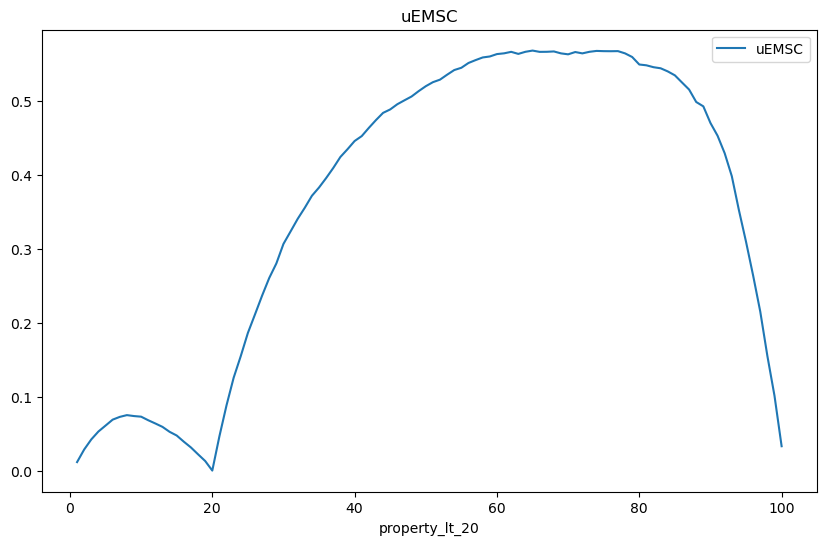

In [104]:
# unit earth movers stochastic conformance
plt.figure(figsize=(10,6))
plt.plot(sorted_attribute_values[1:], uemscs, label="uEMSC")
plt.title("uEMSC")
plt.xlabel(attribute_key)
plt.legend()
plt.show()

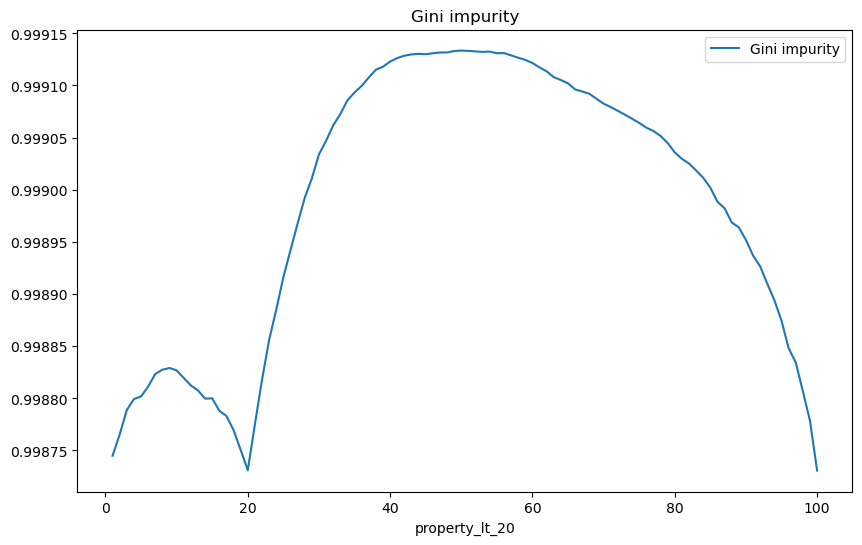

In [105]:
# gini impurity
plt.figure(figsize=(10,6))
plt.plot(sorted_attribute_values[1:], ginis, label="Gini impurity")
plt.title("Gini impurity")
plt.xlabel(attribute_key)
plt.legend()
plt.show()